In [1]:
from time import time
import numexpr as ne
import numpy as np
from matplotlib import pyplot as plt
import blosc2

In [2]:
def bench_expr(num_threads, a, b, c, cparams, chunks):
    ne.set_num_threads(num_threads)  # Set the number of threads for NumExpr evaluation
    # Convert NumPy arrays to compressed arrays using Blosc2
    chunk_root = int(np.sqrt(chunks))
    chunks = (chunk_root, chunk_root)
    a1 = blosc2.asarray(a, chunks=chunks, cparams=cparams)  # Compressed array 'a'
    b1 = blosc2.asarray(b, chunks=chunks, cparams=cparams)  # Compressed array 'b'
    c1 = blosc2.asarray(c, chunks=chunks, cparams=cparams)  # Compressed array 'c'
    # Perform the mathematical operation using LazyExpr: addition, multiplication, and addition of 2
    expr = a1 + b1 * c1 + 2
    t = time()  # Initial time
    res = expr.eval(cparams=cparams)  # Evaluate the LazyExpr expression and get the result
    tt = time() - t  # Calculate elapsed time
    return tt

In [13]:
# Parameters for the benchmark
dtype = np.float64  # Data type for the arrays
dtype_itemsize = np.dtype(dtype).itemsize  # Size of the data type
reshape = [30000, 4000]  # Reshape the arrays
nthreads = 28  # Number of threads by default
chunk_size = 2**20  # Chunk size by default (8 MB in this case)
threads = list(range(1, 33))  # Range of threads to test (max 32)
clevels = [0, 1, 5]  # Compression levels
codecs = [blosc2.Codec.LZ4, blosc2.Codec.ZSTD]  # Compression codecs
codec_names = {blosc2.Codec.LZ4: "LZ4", blosc2.Codec.ZSTD: "ZSTD"}  # Codec names

# Generate chunk sizes from 32 KB to 128 MB
chunk_sizes = []
chunk_sizes2 = []
current_size = 32  # Starting from 32 KB
while current_size <= 128 * 1024:  # Up to 128 MB
    chunk_sizes2.append(current_size)
    chunk_sizes.append(current_size * 1024 // dtype_itemsize)   
    current_size *= 2


In [4]:
# Perform the benchmark
size = reshape[0] * reshape[1]
a = np.linspace(0, 10, num=size, dtype=dtype).reshape(reshape)  
b = np.linspace(0, 10, num=size, dtype=dtype).reshape(reshape)  
c = np.linspace(0, 10, num=size, dtype=dtype).reshape(reshape)  
mega_bytes = (size * dtype_itemsize) // 1024 ** 2  # Total megabytes
speed_threads = {}
speed_chunks = {}

# Calculate execution times for LazyExpr
for codec in codecs:
    speed_threads["No compression"] = {}
    speed_threads[codec_names[codec]] = {}
    speed_chunks["No compression"] = {}
    speed_chunks[codec_names[codec]] = {}
    for clevel in clevels:
        # For each compression level, calculate the execution time for different numbers of threads
        speeds = []
        for num_thread in threads:
            cparams = {"clevel": clevel, "codec": codec, "nthreads": num_thread}
            speed = mega_bytes / bench_expr(num_thread, a, b, c, cparams, chunk_size)
            speeds.append(speed)
        if clevel == 0:
            speed_threads["No compression"][clevel] = speeds
        else:
            speed_threads[codec_names[codec]][clevel] = speeds
        # For each compression level, calculate the execution time for different chunk sizes
        speeds = []
        for chunksize in chunk_sizes:
            cparams = {"clevel": clevel, "codec": codec, "nthreads": nthreads}
            speed = mega_bytes / bench_expr(nthreads, a, b, c, cparams, chunksize)
            speeds.append(speed)
        if clevel == 0:
            speed_chunks["No compression"][clevel] = speeds
        else:
            speed_chunks[codec_names[codec]][clevel] = speeds


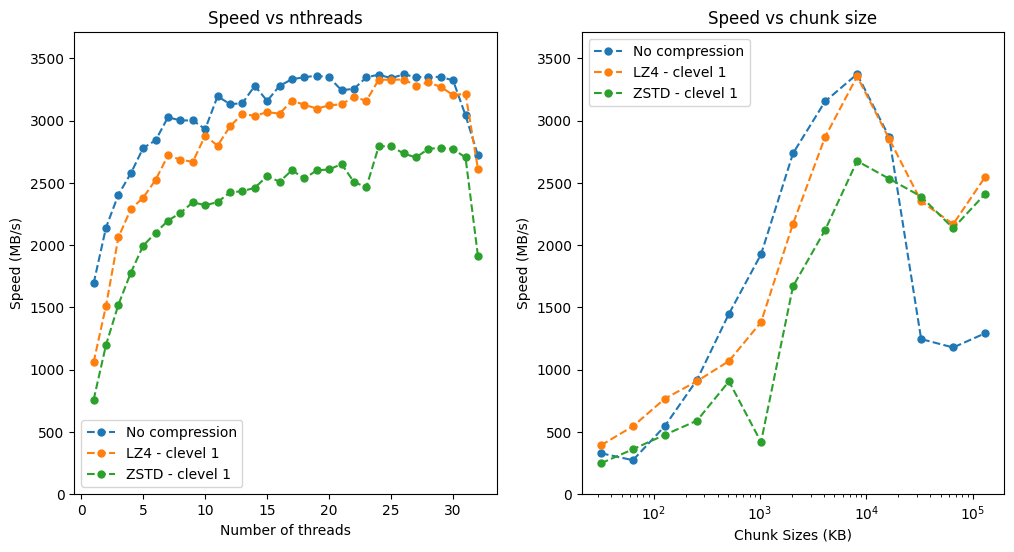

In [15]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
# Compute the limit of speeds for the y-axis
limit_y = max([max(speed_threads["No compression"][0])] +
              [max(speed_chunks["No compression"][0])] +
              [max(speed_threads[codec][clevel])
               for (codec, clevel) in zip(codec_names.values(), clevels[1:])
               ] +
              [max(speed_chunks[codec][clevel])
               for (codec, clevel) in zip(codec_names.values(), clevels[1:])
              ]) * 1.1

# Plot for "No compression"
ax1.plot(threads, speed_threads["No compression"][0], marker='o', markersize=5, linestyle='--', label="No compression")
ax2.plot(chunk_sizes2, speed_chunks["No compression"][0], marker='o', markersize=5, linestyle='--', label="No compression")

# Plot for codecs and compression levels
for codec in codec_names.values():
    for clevel in clevels[1:2]:
        ax1.plot(threads, speed_threads[codec][clevel], marker='o', markersize=5, linestyle='--', label=f"{codec} - clevel {clevel}")
        ax2.plot(chunk_sizes2, speed_chunks[codec][clevel], marker='o', markersize=5, linestyle='--', label=f"{codec} - clevel {clevel}")

ax1.set_xlabel('Number of threads')  # Set x-axis label
ax1.set_ylabel('Speed (MB/s)')  # Set y-axis label
ax1.set_title('Speed vs nthreads')  # Set title
ax1.legend()  # Add legend
ax1.set_ylim(0, limit_y)  # Set y-axis limit
ax2.set_xlabel('Chunk Sizes (KB)')  # Set x-axis label
ax2.set_ylabel('Speed (MB/s)')  # Set y-axis label
ax2.set_title('Speed vs chunk size')  # Set title
ax2.legend()  # Add legend
ax2.set_ylim(0, limit_y)  # Set y-axis limit
ax2.set_xscale('log')
plt.show()  # Show the plot